In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.constraints import Interval
from gpytorch.constraints import GreaterThan
from scipy.stats import norm
import shutil


DTYPE = torch.get_default_dtype()

In [2]:
FONTSIZE = 18

# Try LaTeX settings, fall back gracefully
try:
    if shutil.which("latex") is not None:
        plt.rc("text", usetex=True)
        plt.rc(
            "text.latex",
            preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}",
        )
        plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
    else:
        raise RuntimeError("LaTeX not found")
except Exception:
    # Fallback to default matplotlib serif font
    plt.rc("text", usetex=False)
    plt.rc("font", family="serif", size=FONTSIZE)

plt.rc("axes", titlesize="medium")

# Define color cycle
colors = [f"C{i}" for i in range(5)]

In [3]:
# Get some simple toy function
def generate_data(n_samples, unc=0.2, seed=None):
    """
    Simple 1D regression problem based
    """
    if seed is not None:
        np.random.seed(seed)
    x = np.concatenate((np.random.uniform(-1, -0.22, n_samples // 2), np.random.uniform(0.22, 1, n_samples - n_samples // 2)))
    y = 0.5 * np.sin(23*x) + x/2
    y_noise = y + np.random.randn(n_samples) * unc #* (x+1) + np.random.randn(n_samples) * unc/2
    return x, y_noise

In [17]:
x_np, y_np = generate_data(2000, unc=0.1, seed=42)
Y_STD = y_np.std()
Y_MEAN = y_np.mean()
y_train_scaled = (y_np - Y_MEAN) / Y_STD
x_train = torch.tensor(x_np, dtype=DTYPE).unsqueeze(-1)
y_train = torch.tensor(y_train_scaled, dtype=DTYPE)

In [18]:
# === GP Model ===
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=Interval(0.001, 0.1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# === Instantiate model and likelihood ===
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [19]:
# === Training mode ===
model.train()
likelihood.train()
training_iter = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# === Training loop ===
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))


Iter 10/100 - Loss: 0.473   lengthscale: 0.071   noise: 0.312
Iter 20/100 - Loss: 0.110   lengthscale: 0.083   noise: 0.126
Iter 30/100 - Loss: -0.128   lengthscale: 0.089   noise: 0.052
Iter 40/100 - Loss: -0.141   lengthscale: 0.092   noise: 0.031
Iter 50/100 - Loss: -0.143   lengthscale: 0.093   noise: 0.033
Iter 60/100 - Loss: -0.153   lengthscale: 0.094   noise: 0.042
Iter 70/100 - Loss: -0.153   lengthscale: 0.094   noise: 0.043
Iter 80/100 - Loss: -0.155   lengthscale: 0.095   noise: 0.040
Iter 90/100 - Loss: -0.154   lengthscale: 0.095   noise: 0.039
Iter 100/100 - Loss: -0.157   lengthscale: 0.095   noise: 0.040


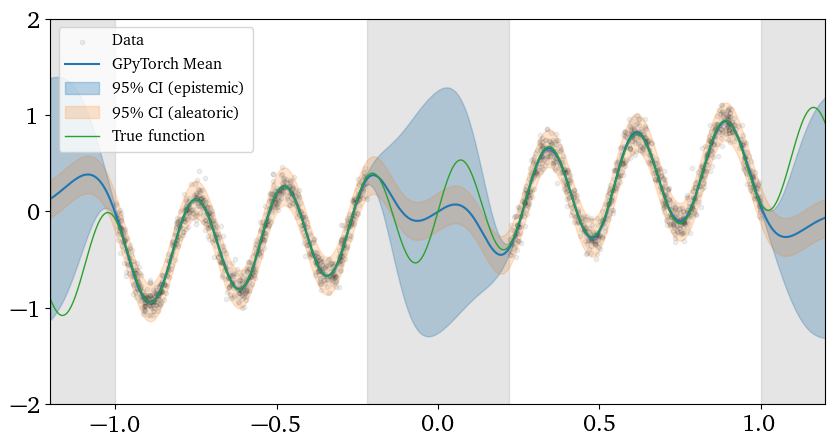

In [25]:
# === Evaluation ===
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Xtest = torch.linspace(-1.2, 1.2, 2000).unsqueeze(-1)
    pred_raw = model(Xtest)
    pred = likelihood(pred_raw)
    mean = pred.mean * Y_STD + Y_MEAN  # Rescale mean
    std_epi = pred_raw.variance.sqrt() * Y_STD
    std_all = pred.variance.sqrt() * Y_STD
    std_alea = torch.sqrt(std_all**2 - std_epi**2)

    z = norm.ppf(0.975)  # two-sided: (1 + 0.95)/2
    lower = mean - z * std_epi
    upper = mean + z * std_epi
    lower_alea = mean - z * std_alea
    upper_alea = mean + z * std_alea
    #lower, upper = pred.confidence_region()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.scatter(x_train.numpy(), y_np, s=10, alpha=1/16, label='Data', color="k")
    plt.plot(Xtest.numpy(), mean.numpy(), label='GPyTorch Mean')
    plt.fill_between(Xtest.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.3, label=r'95\% CI (epistemic)', color="C0", zorder=-10)
    plt.fill_between(Xtest.squeeze().numpy(), lower_alea.numpy(), upper_alea.numpy(), alpha=0.2, label=r'95\% CI (aleatoric)', color="C1", zorder=-10)
    plt.axvspan(-0.22, 0.22, color='gray', alpha=0.2)
    plt.axvspan(1, 1.2, color='gray', alpha=0.2)
    plt.axvspan(-1.2, -1.0, color='gray', alpha=0.2)
    y = 0.5 * torch.sin(23*Xtest) + Xtest/2
    plt.plot(Xtest, y, color="C2", label='True function', linewidth=1)
    plt.legend(fontsize=FONTSIZE-6, loc='upper left')
    plt.ylim(-2,2)
    plt.xlim(-1.2,1.2)
    plt.show()